In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

customers = pd.read_csv("../data/raw/olist_customers_dataset.csv")
geolocations = pd.read_csv("../data/raw/olist_geolocation_dataset.csv")
order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../data/raw/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("../data/raw/olist_order_reviews_dataset.csv")
orders = pd.read_csv("../data/raw/olist_orders_dataset.csv")
products = pd.read_csv("../data/raw/olist_products_dataset.csv")
sellers = pd.read_csv("../data/raw/olist_sellers_dataset.csv")
category_translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

print("Customers:", customers.shape)
print("Orders:", orders.shape)
print("Order Items:", order_items.shape)


Customers: (99441, 5)
Orders: (99441, 8)
Order Items: (112650, 7)


In [10]:
orders_customers = orders.merge(customers, on='customer_id', how='left')
orders_items = orders_customers.merge(order_items, on='order_id', how='left')
orders_items_payments = orders_items.merge(order_payments, on='order_id', how='left')

df_full = orders_items_payments.merge(order_reviews, on='order_id', how='left')

print("Final dataset shape", df_full.shape)
print(df_full.head())

Final dataset shape (119143, 28)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017

In [13]:
df_full['order_purchase_timestamp'] = pd.to_datetime(df_full['order_purchase_timestamp'])

last_purchase = df_full.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase['days_since_last_purchase'] = (df_full['order_purchase_timestamp'].max() - last_purchase['order_purchase_timestamp']).dt.days

# Churn jika 180 hari tidak beli lagi
last_purchase['churn'] = (last_purchase['days_since_last_purchase'] > 180).astype(int)

df_full = df_full.merge(last_purchase[['customer_unique_id', 'days_since_last_purchase', 'churn']], on='customer_unique_id', how='left')

print(df_full[['customer_unique_id', 'days_since_last_purchase', 'churn']].head())

                 customer_unique_id  days_since_last_purchase  churn
0  7c396fd4830fd04220f754e42b4e5bff                       380      1
1  7c396fd4830fd04220f754e42b4e5bff                       380      1
2  7c396fd4830fd04220f754e42b4e5bff                       380      1
3  af07308b275d755c9edb36a90c618231                        84      0
4  3a653a41f6f9fc3d2a113cf8398680e8                        70      0


# Analisis churn rate

Churn rate: 71.00%


C:\Users\WINDOWS X\AppData\Local\Temp\ipykernel_5532\394526763.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=df_full, palette='viridis')


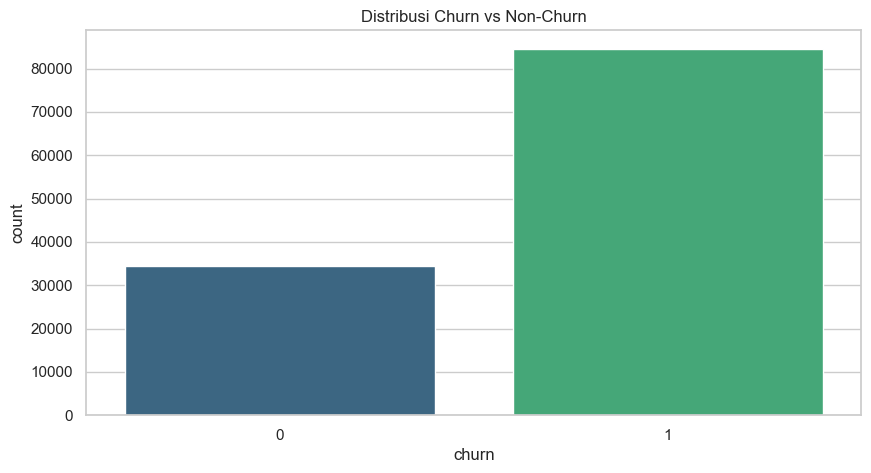

In [15]:
churn_rate = df_full['churn'].mean()
print(f"Churn rate: {churn_rate:.2%}")

sns.countplot(x='churn', data=df_full, palette='viridis')
plt.title('Distribusi Churn vs Non-Churn')
plt.show()

# Insight Awal


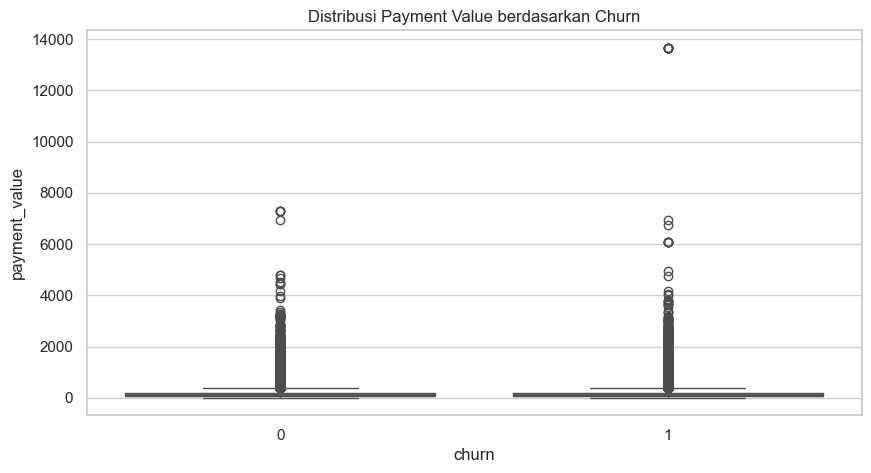

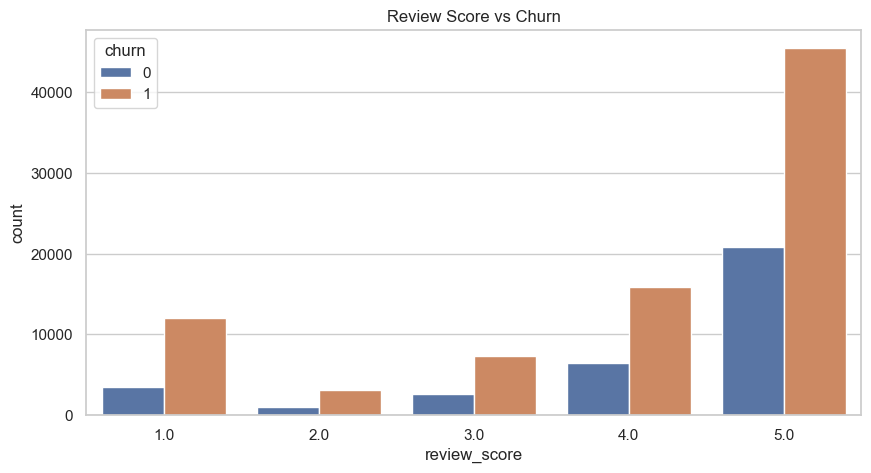

In [16]:
sns.boxplot(x='churn', y='payment_value', data=df_full)
plt.title('Distribusi Payment Value berdasarkan Churn')
plt.show()

sns.countplot(x='review_score', hue='churn', data=df_full)
plt.title('Review Score vs Churn')
plt.show()